# Import packages


In [1]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings

# Load data


In [2]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


In [3]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 7
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

In [4]:
train_data, test_data, all_data, test_data_start_list = load_data(stock_name, date_predict_start, data_range, slide_range, n_slide)

In [5]:
all_data.iloc[23449]

Open            4.228290e+03
High            4.236390e+03
Low             4.188130e+03
Close           4.188430e+03
Volume          4.560700e+09
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Name: 2021-05-10, dtype: float64

In [6]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0
...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0


# Data preprocessing


In [7]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [8]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [9]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [10]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [11]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [12]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [13]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [14]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [15]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [16]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [17]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [18]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [19]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [20]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [21]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [22]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [23]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [24]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [25]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [26]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [27]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 7
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

In [28]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

In [29]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)


In [30]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [31]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.random import shuffle

In [32]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        for x in range(base_day+prediction_day, len(scaled_data)):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [33]:
base_day = 20
prediction_day = base_day
slide = base_day

In [34]:
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)

In [35]:
x_train['data_0'].shape

(210, 20, 1)

In [36]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units=prediction_day))
    return model

In [37]:
input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)

In [38]:
def build_Lstm_model(prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [39]:
model = build_Lstm_model(prediction_day, input_shape)

In [40]:
from tqdm import tqdm

In [41]:
def train_Lstm_model():
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [42]:
history = train_Lstm_model()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
6/6 [==============================] - 41s 2s/step - loss: 0.0384 - val_loss: 0.1432
Epoch 2/25
6/6 [==============================] - 1s 248ms/step - loss: 0.0347 - val_loss: 0.2176
Epoch 3/25
6/6 [==============================] - 2s 261ms/step - loss: 0.0304 - val_loss: 0.1959
Epoch 4/25
6/6 [==============================] - 1s 245ms/step - loss: 0.0295 - val_loss: 0.2242
Epoch 5/25
6/6 [==============================] - 1s 252ms/step - loss: 0.0292 - val_loss: 0.2087
Epoch 6/25
6/6 [==============================] - 1s 220ms/step - loss: 0.0279 - val_loss: 0.2309
Epoch 6: early stopping


 10%|█         | 1/10 [00:48<07:16, 48.55s/it]

Epoch 1/25
6/6 [==============================] - 61s 3s/step - loss: 0.0549 - val_loss: 0.2650
Epoch 2/25
6/6 [==============================] - 1s 233ms/step - loss: 0.0437 - val_loss: 0.2583
Epoch 3/25
6/6 [==============================] - 2s 305ms/step - loss: 0.0400 - val_loss: 0.2542
Epoch 4/25
6/6 [==============================] - 2s 377ms/step - loss: 0.0389 - val_loss: 0.2605
Epoch 5/25
6/6 [==============================] - 2s 312ms/step - loss: 0.0374 - val_loss: 0.2769
Epoch 6/25
6/6 [==============================] - 2s 373ms/step - loss: 0.0373 - val_loss: 0.2708
Epoch 7/25
6/6 [==============================] - 2s 424ms/step - loss: 0.0361 - val_loss: 0.2760
Epoch 8/25
6/6 [==============================] - 2s 296ms/step - loss: 0.0369 - val_loss: 0.3096
Epoch 8: early stopping


 20%|██        | 2/10 [02:03<08:33, 64.16s/it]

Epoch 1/25
6/6 [==============================] - 107s 7s/step - loss: 0.1079 - val_loss: 0.2786
Epoch 2/25
6/6 [==============================] - 2s 409ms/step - loss: 0.0668 - val_loss: 0.2943
Epoch 3/25
6/6 [==============================] - 2s 366ms/step - loss: 0.0584 - val_loss: 0.3140
Epoch 4/25
6/6 [==============================] - 2s 334ms/step - loss: 0.0586 - val_loss: 0.3268
Epoch 5/25
6/6 [==============================] - 2s 265ms/step - loss: 0.0532 - val_loss: 0.3343
Epoch 6/25
6/6 [==============================] - 2s 336ms/step - loss: 0.0541 - val_loss: 0.3343
Epoch 6: early stopping


 30%|███       | 3/10 [04:00<10:18, 88.40s/it]

Epoch 1/25
6/6 [==============================] - 107s 6s/step - loss: 0.1504 - val_loss: 0.2529
Epoch 2/25
6/6 [==============================] - 4s 759ms/step - loss: 0.0765 - val_loss: 0.2460
Epoch 3/25
6/6 [==============================] - 4s 704ms/step - loss: 0.0693 - val_loss: 0.2381
Epoch 4/25
6/6 [==============================] - 3s 589ms/step - loss: 0.0666 - val_loss: 0.2228
Epoch 5/25
6/6 [==============================] - 4s 667ms/step - loss: 0.0612 - val_loss: 0.2156
Epoch 6/25
6/6 [==============================] - 4s 770ms/step - loss: 0.0634 - val_loss: 0.2092
Epoch 7/25
6/6 [==============================] - 4s 624ms/step - loss: 0.0599 - val_loss: 0.1997
Epoch 8/25
6/6 [==============================] - 5s 873ms/step - loss: 0.0600 - val_loss: 0.2167
Epoch 9/25
6/6 [==============================] - 6s 1s/step - loss: 0.0584 - val_loss: 0.1977
Epoch 10/25
6/6 [==============================] - 5s 837ms/step - loss: 0.0605 - val_loss: 0.2137
Epoch 11/25
6/6 [======

 40%|████      | 4/10 [07:28<13:32, 135.44s/it]

Epoch 1/25
6/6 [==============================] - 171s 12s/step - loss: 0.1393 - val_loss: 0.2966
Epoch 2/25
6/6 [==============================] - 4s 733ms/step - loss: 0.0795 - val_loss: 0.2604
Epoch 3/25
6/6 [==============================] - 4s 672ms/step - loss: 0.0726 - val_loss: 0.2448
Epoch 4/25
6/6 [==============================] - 5s 855ms/step - loss: 0.0690 - val_loss: 0.1652
Epoch 5/25
6/6 [==============================] - 5s 802ms/step - loss: 0.0653 - val_loss: 0.1204
Epoch 6/25
6/6 [==============================] - 5s 900ms/step - loss: 0.0620 - val_loss: 0.0859
Epoch 7/25
6/6 [==============================] - 5s 848ms/step - loss: 0.0588 - val_loss: 0.0565
Epoch 8/25
6/6 [==============================] - 5s 933ms/step - loss: 0.0569 - val_loss: 0.0448
Epoch 9/25
6/6 [==============================] - 6s 1s/step - loss: 0.0568 - val_loss: 0.0445
Epoch 10/25
6/6 [==============================] - 6s 1s/step - loss: 0.0557 - val_loss: 0.0600
Epoch 11/25
6/6 [========

 50%|█████     | 5/10 [11:24<14:19, 171.86s/it]

Epoch 1/25
6/6 [==============================] - 167s 12s/step - loss: 0.0548 - val_loss: 0.1383
Epoch 2/25
6/6 [==============================] - 5s 800ms/step - loss: 0.0363 - val_loss: 0.1537
Epoch 3/25
6/6 [==============================] - 5s 763ms/step - loss: 0.0338 - val_loss: 0.1219
Epoch 4/25
6/6 [==============================] - 5s 902ms/step - loss: 0.0296 - val_loss: 0.1106
Epoch 5/25
6/6 [==============================] - 5s 829ms/step - loss: 0.0295 - val_loss: 0.1789
Epoch 6/25
6/6 [==============================] - 4s 674ms/step - loss: 0.0277 - val_loss: 0.3110
Epoch 7/25
6/6 [==============================] - 5s 800ms/step - loss: 0.0266 - val_loss: 0.2231
Epoch 8/25
6/6 [==============================] - 5s 920ms/step - loss: 0.0262 - val_loss: 0.2551
Epoch 9/25
6/6 [==============================] - 5s 932ms/step - loss: 0.0272 - val_loss: 0.3843
Epoch 9: early stopping


 60%|██████    | 6/10 [14:52<12:15, 183.97s/it]

Epoch 1/25
6/6 [==============================] - 179s 11s/step - loss: 0.1154 - val_loss: 0.2502
Epoch 2/25
6/6 [==============================] - 6s 1s/step - loss: 0.0506 - val_loss: 0.2310
Epoch 3/25
6/6 [==============================] - 7s 1s/step - loss: 0.0373 - val_loss: 0.2385
Epoch 4/25
6/6 [==============================] - 8s 1s/step - loss: 0.0328 - val_loss: 0.2617
Epoch 5/25
6/6 [==============================] - 7s 1s/step - loss: 0.0318 - val_loss: 0.3079
Epoch 6/25
6/6 [==============================] - 6s 949ms/step - loss: 0.0287 - val_loss: 0.3011
Epoch 7/25
6/6 [==============================] - 8s 1s/step - loss: 0.0262 - val_loss: 0.3460
Epoch 7: early stopping


 70%|███████   | 7/10 [18:36<09:51, 197.10s/it]

Epoch 1/25
6/6 [==============================] - 157s 7s/step - loss: 0.1491 - val_loss: 0.6073
Epoch 2/25
6/6 [==============================] - 5s 851ms/step - loss: 0.0548 - val_loss: 0.4065
Epoch 3/25
6/6 [==============================] - 4s 732ms/step - loss: 0.0517 - val_loss: 0.5709
Epoch 4/25
6/6 [==============================] - 5s 838ms/step - loss: 0.0360 - val_loss: 0.5118
Epoch 5/25
6/6 [==============================] - 4s 768ms/step - loss: 0.0333 - val_loss: 0.6838
Epoch 6/25
6/6 [==============================] - 6s 1s/step - loss: 0.0288 - val_loss: 0.5602
Epoch 7/25
6/6 [==============================] - 4s 770ms/step - loss: 0.0263 - val_loss: 0.7930
Epoch 7: early stopping


 80%|████████  | 8/10 [21:45<06:29, 194.57s/it]

Epoch 1/25
6/6 [==============================] - 170s 3s/step - loss: 0.1774 - val_loss: 0.7484
Epoch 2/25
6/6 [==============================] - 4s 611ms/step - loss: 0.0758 - val_loss: 0.5330
Epoch 3/25
6/6 [==============================] - 3s 511ms/step - loss: 0.0484 - val_loss: 0.6564
Epoch 4/25
6/6 [==============================] - 3s 480ms/step - loss: 0.0414 - val_loss: 0.7811
Epoch 5/25
6/6 [==============================] - 3s 483ms/step - loss: 0.0359 - val_loss: 0.7066
Epoch 6/25
6/6 [==============================] - 3s 442ms/step - loss: 0.0330 - val_loss: 0.8692
Epoch 7/25
6/6 [==============================] - 3s 571ms/step - loss: 0.0308 - val_loss: 0.8515
Epoch 7: early stopping


 90%|█████████ | 9/10 [24:56<03:13, 193.52s/it]

Epoch 1/25
6/6 [==============================] - 131s 6s/step - loss: 0.2037 - val_loss: 0.7127
Epoch 2/25
6/6 [==============================] - 2s 434ms/step - loss: 0.0863 - val_loss: 0.5144
Epoch 3/25
6/6 [==============================] - 3s 505ms/step - loss: 0.0553 - val_loss: 0.7244
Epoch 4/25
6/6 [==============================] - 3s 473ms/step - loss: 0.0465 - val_loss: 0.6084
Epoch 5/25
6/6 [==============================] - 2s 419ms/step - loss: 0.0400 - val_loss: 0.7342
Epoch 6/25
6/6 [==============================] - 3s 517ms/step - loss: 0.0371 - val_loss: 0.6587
Epoch 7/25
6/6 [==============================] - 3s 439ms/step - loss: 0.0356 - val_loss: 0.7800
Epoch 7: early stopping


100%|██████████| 10/10 [27:25<00:00, 164.60s/it]


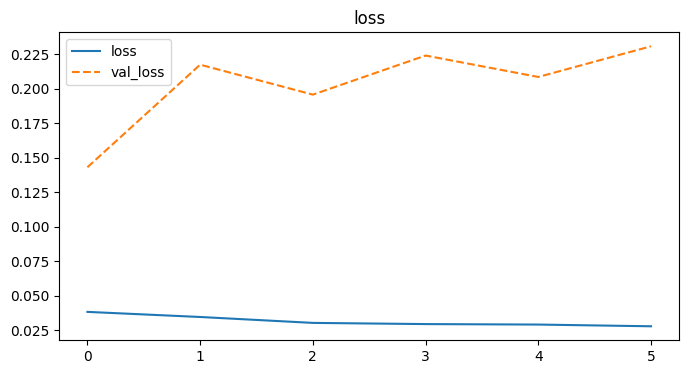

In [43]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history['data_0'].history['loss'], label='loss')
plt.plot(history['data_0'].history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()


In [44]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [45]:
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

In [46]:
test_data['data_2']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-01-31,3282.330078,3282.330078,3214.679932,3225.520020,4529700000,0.0,0.0,NaN,3225.52002,valley
1,2020-02-03,3235.659912,3268.439941,3235.659912,3248.919922,3760460000,0.0,0.0,NaN,NaN,NaN
2,2020-02-04,3280.610107,3306.919922,3280.610107,3297.590088,3996900000,0.0,0.0,NaN,NaN,NaN
3,2020-02-05,3324.909912,3337.580078,3313.750000,3334.689941,4121480000,0.0,0.0,NaN,NaN,NaN
4,2020-02-06,3344.919922,3347.959961,3334.389893,3345.780029,3887250000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-01-21,3857.459961,3861.449951,3845.050049,3853.070068,4501760000,0.0,0.0,NaN,NaN,NaN
246,2021-01-22,3844.239990,3852.310059,3830.409912,3841.469971,5110890000,0.0,0.0,NaN,NaN,NaN
247,2021-01-25,3851.679932,3859.229980,3797.159912,3855.360107,7000840000,0.0,0.0,3855.360107,NaN,peak
248,2021-01-26,3862.959961,3870.899902,3847.780029,3849.620117,6137500000,0.0,0.0,NaN,NaN,NaN


In [47]:
def predicting_creat_processed_signal_Lstm(x_test, test_data):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [48]:
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data)

1/1 [==============================] - 7s 7s/step


In [49]:
processed_signal['data_0'][0]

,Close
0,0.182952
1,0.161655
2,0.153890
3,0.134282
4,0.113189
...,...
235,0.081709
236,0.087174
237,0.124639
238,0.132627


In [50]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)


In [51]:
# processed_signal = processed_signal_FFT

In [52]:
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

In [53]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [54]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [55]:
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)

In [56]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [57]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [58]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

            s_date t_date  lead ans_date      pv  error best_fit
data_0  2020-01-02    NaN   9.0      NaN  valley  10.52        0
data_1  2020-01-16    NaN   1.0      NaN  valley    9.3        0
data_2  2020-01-31    NaN   9.0      NaN    peak  10.27        0
data_3  2020-02-14    NaN  -3.0      NaN    peak   9.42        0
data_4  2020-03-02    NaN   8.0      NaN  valley  10.75        0
data_5  2020-03-16    NaN  -7.0      NaN    peak   9.81        0
data_6  2020-03-30    NaN   1.0      NaN  valley  10.94        0
data_7  2020-04-14    NaN   2.0      NaN  valley   8.46        0
data_8  2020-04-28    NaN  17.0      NaN    peak   9.72        0
data_9  2020-05-12    NaN  -2.0      NaN  valley   9.37        0


In [59]:
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

            s_date      t_date  lead    ans_date      pv  error best_fit
data_0  2020-01-02  2020-01-17   9.0  2020-01-31  valley  10.52        0
data_1  2020-01-16  2020-01-30   1.0  2020-01-31  valley    9.3        0
data_2  2020-01-31  2020-02-05   9.0  2020-02-19    peak  10.27        0
data_3  2020-02-14  2020-02-24  -3.0  2020-02-19    peak   9.42        0
data_4  2020-03-02  2020-03-11   8.0  2020-03-23  valley  10.75        0
data_5  2020-03-16  2020-04-06  -7.0  2020-03-26    peak   9.81        0
data_6  2020-03-30  2020-03-31   1.0  2020-04-01  valley  10.94        0
data_7  2020-04-14  2020-04-17   2.0  2020-04-21  valley   8.46        0
data_8  2020-04-28  2020-05-13  17.0  2020-06-08    peak   9.72        0
data_9  2020-05-12  2020-05-15  -2.0  2020-05-13  valley   9.37        0


In [60]:
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  5.9
            s_date      t_date  lead    ans_date      pv  error best_fit
data_0  2020-01-02  2020-01-17   9.0  2020-01-31  valley  10.52        0
data_1  2020-01-16  2020-01-30   1.0  2020-01-31  valley    9.3        0
data_2  2020-01-31  2020-02-05   9.0  2020-02-19    peak  10.27        0
data_3  2020-02-14  2020-02-24  -3.0  2020-02-19    peak   9.42        0
data_4  2020-03-02  2020-03-11   8.0  2020-03-23  valley  10.75        0
data_5  2020-03-16  2020-04-06  -7.0  2020-03-26    peak   9.81        0
data_6  2020-03-30  2020-03-31   1.0  2020-04-01  valley  10.94        0
data_7  2020-04-14  2020-04-17   2.0  2020-04-21  valley   8.46        0
data_8  2020-04-28  2020-05-13  17.0  2020-06-08    peak   9.72        0
data_9  2020-05-12  2020-05-15  -2.0  2020-05-13  valley   9.37        0


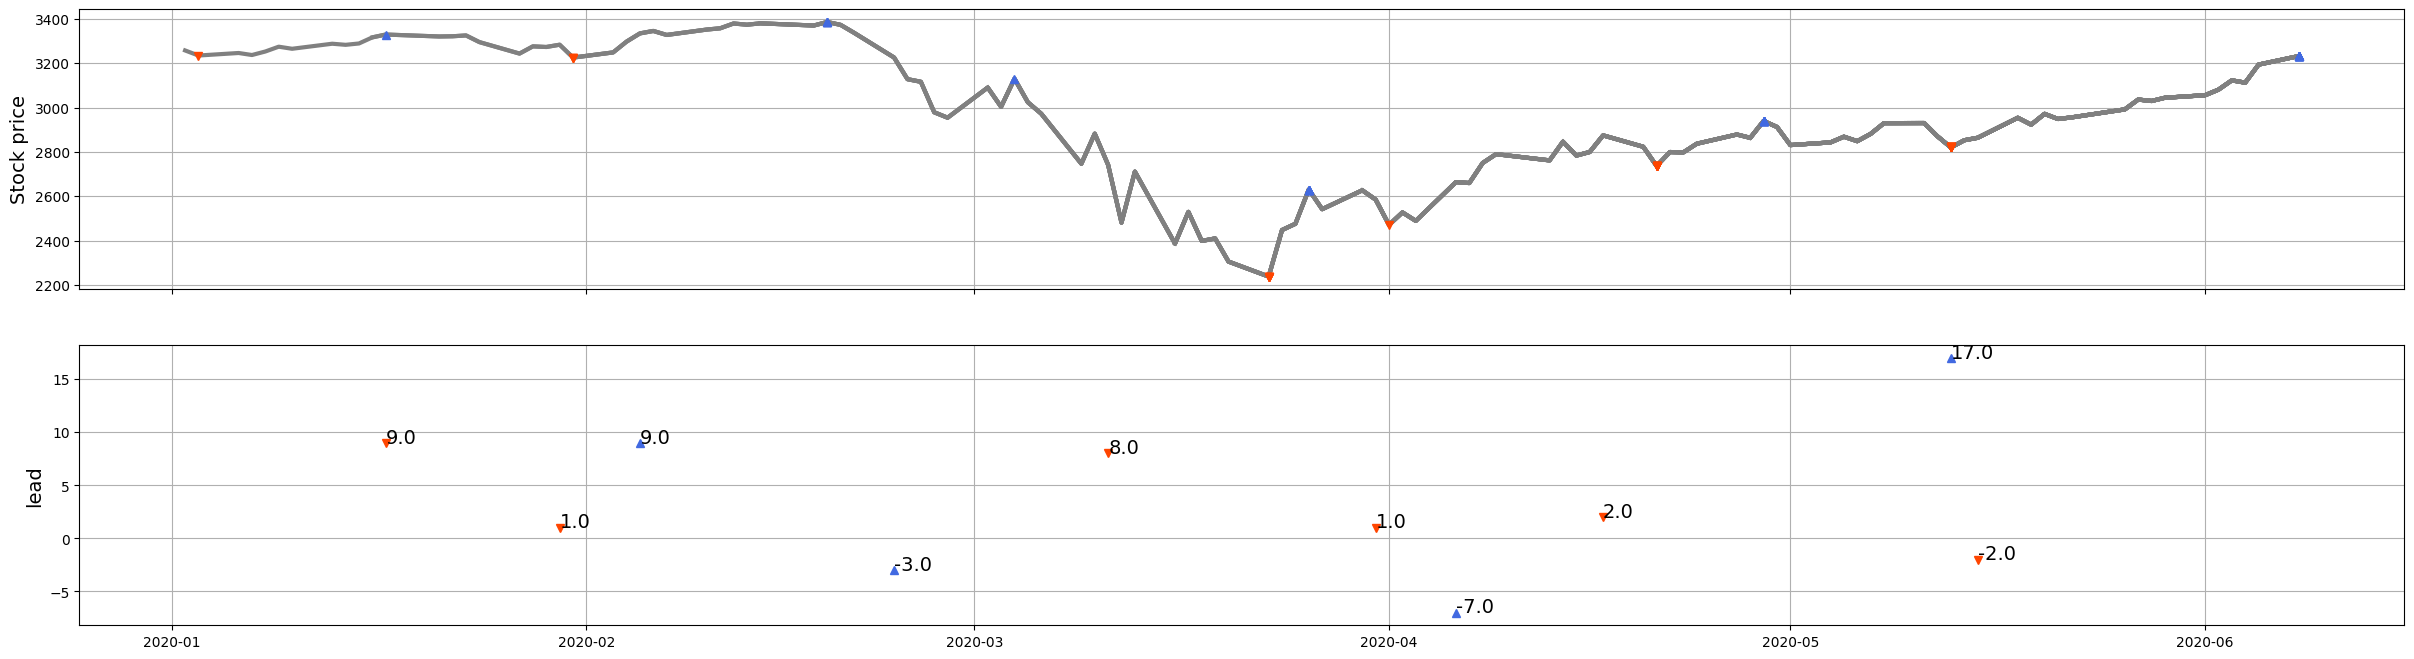

In [61]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

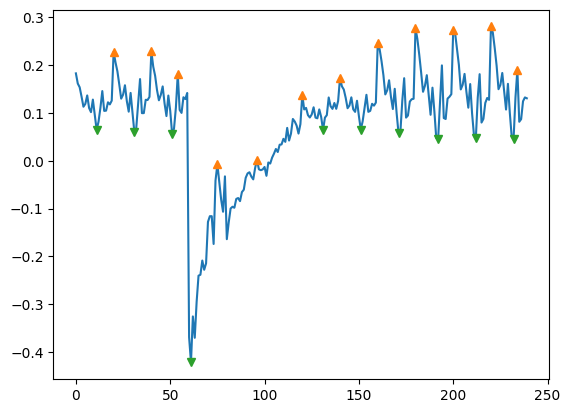

In [62]:
plt.plot(processed_signal['data_0'][0]['Close'])
plt.plot(processed_signal['data_0'][0]['peaks'], '^')
plt.plot(processed_signal['data_0'][0]['valleys'], 'v')

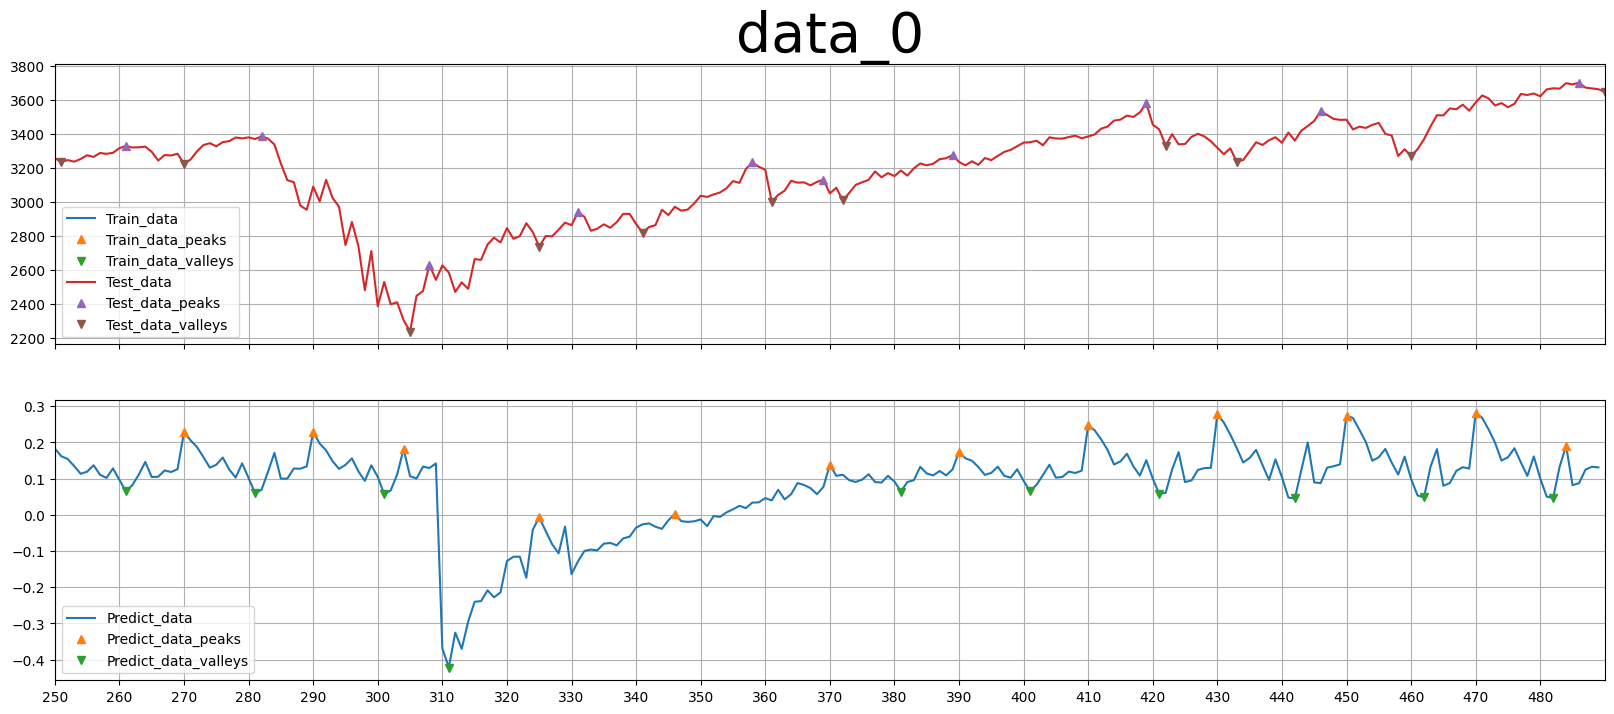

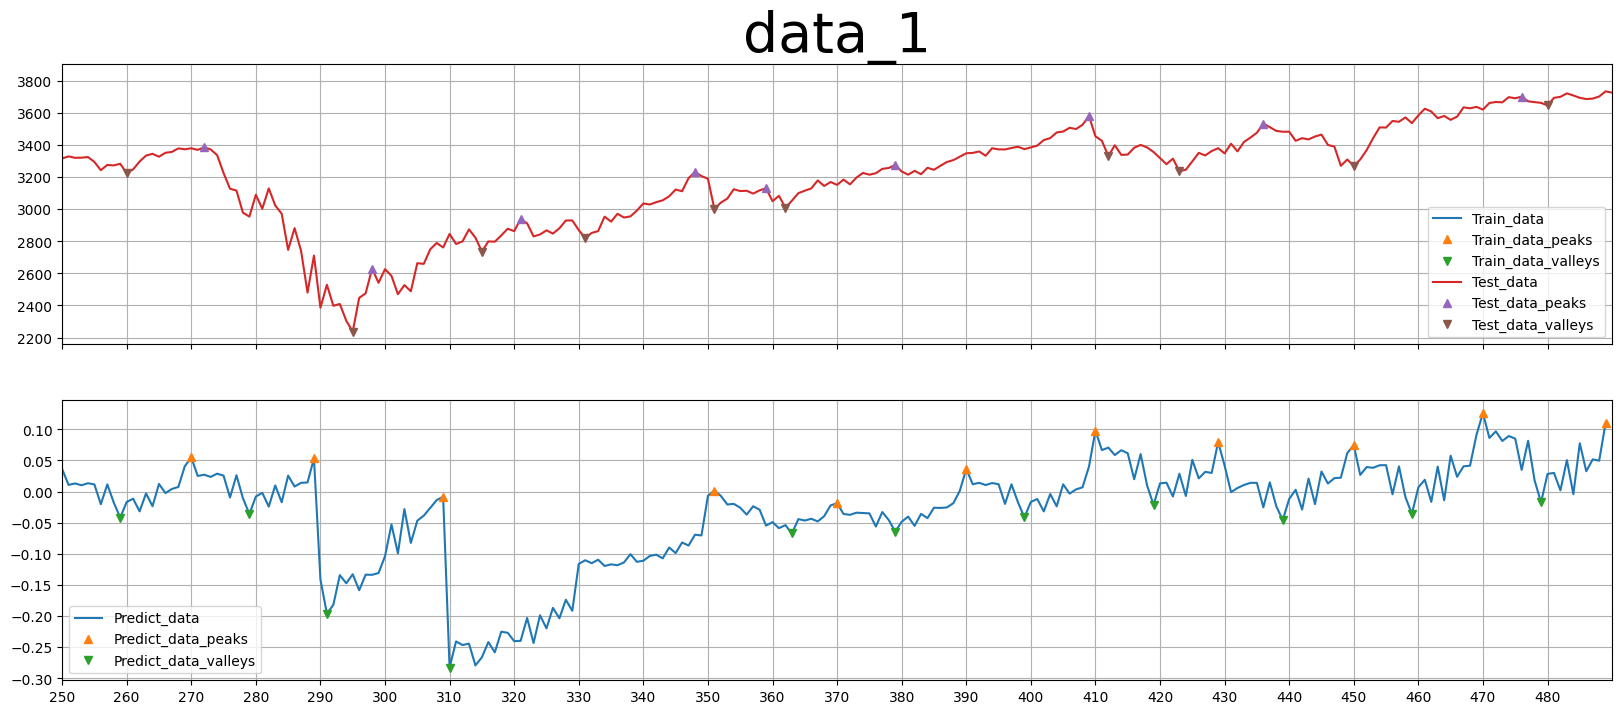

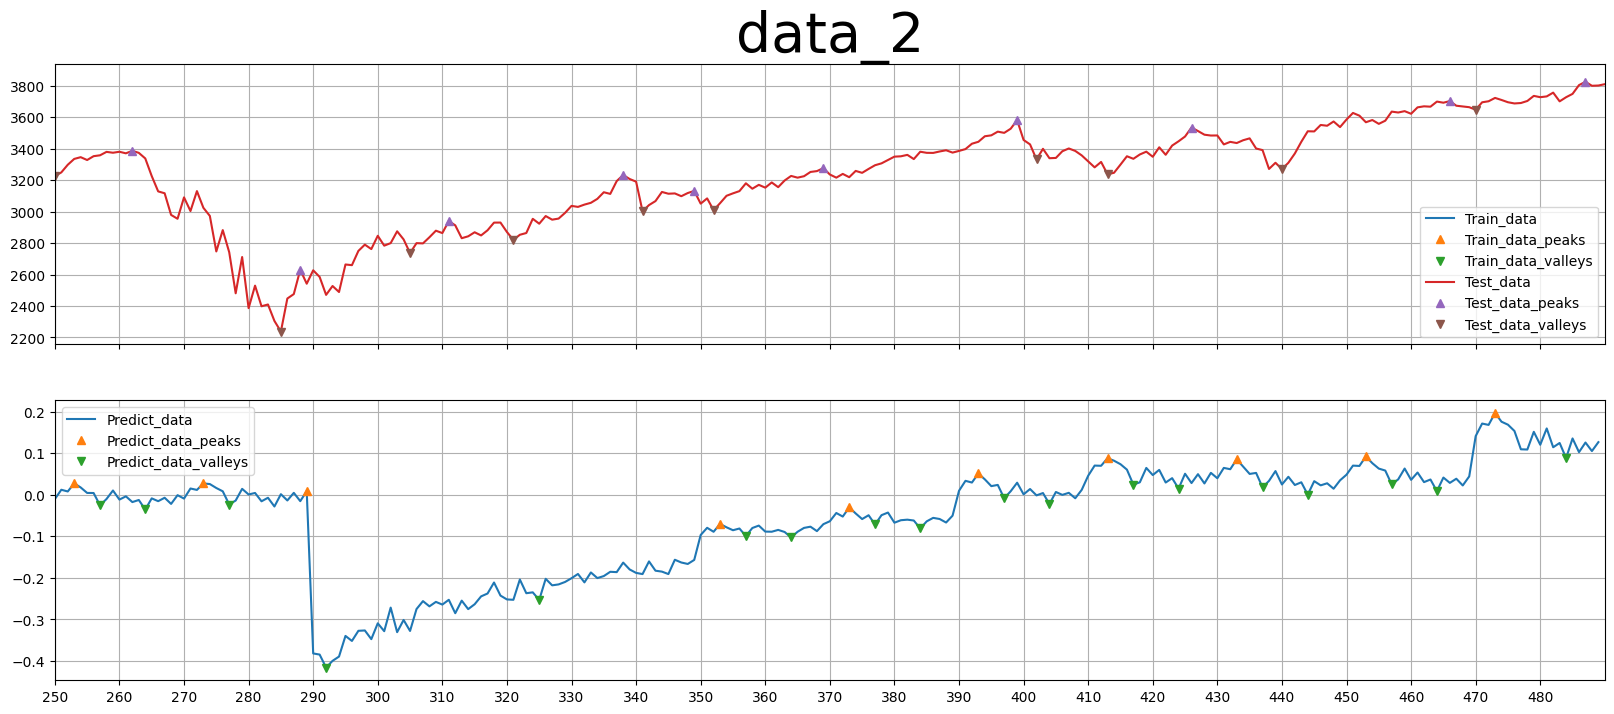

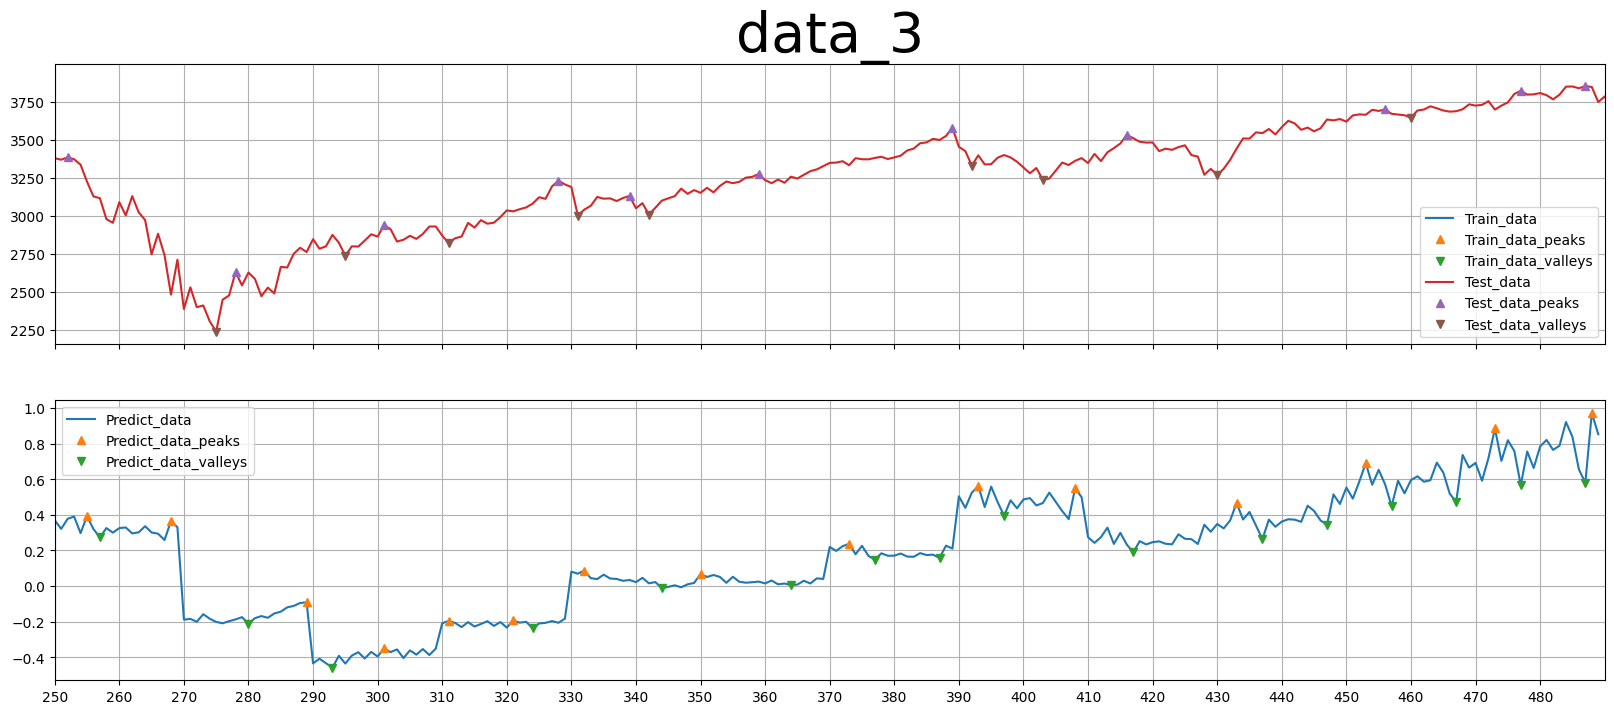

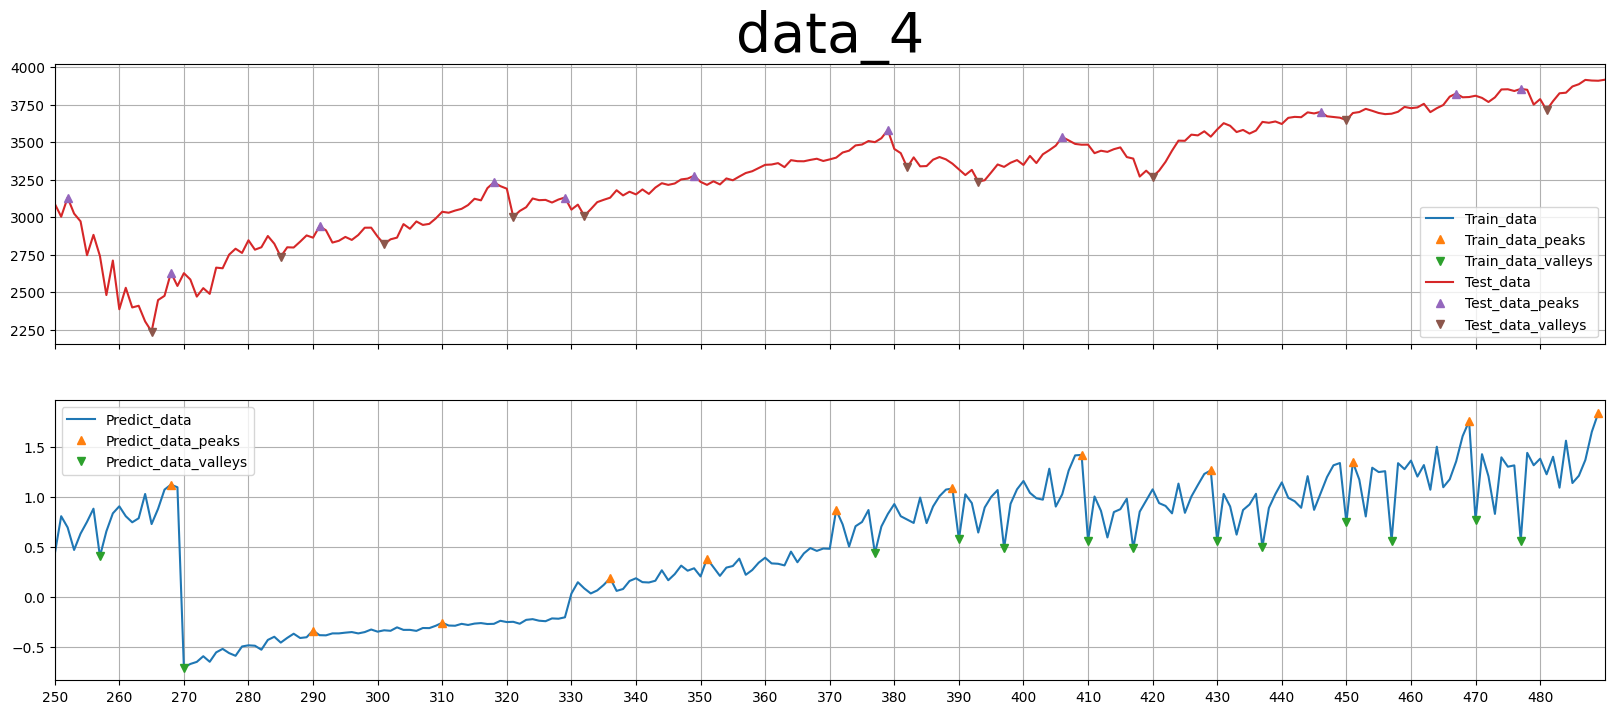

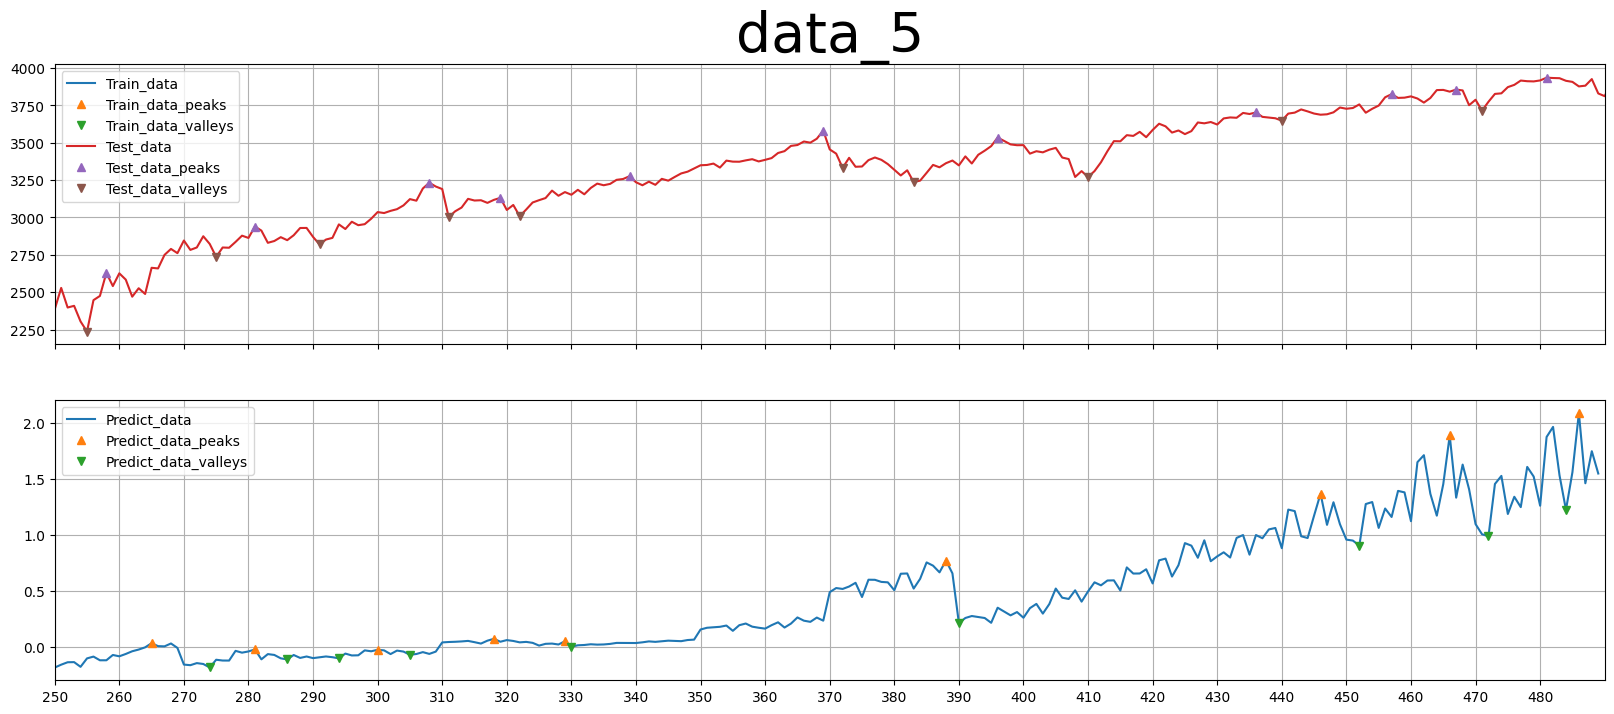

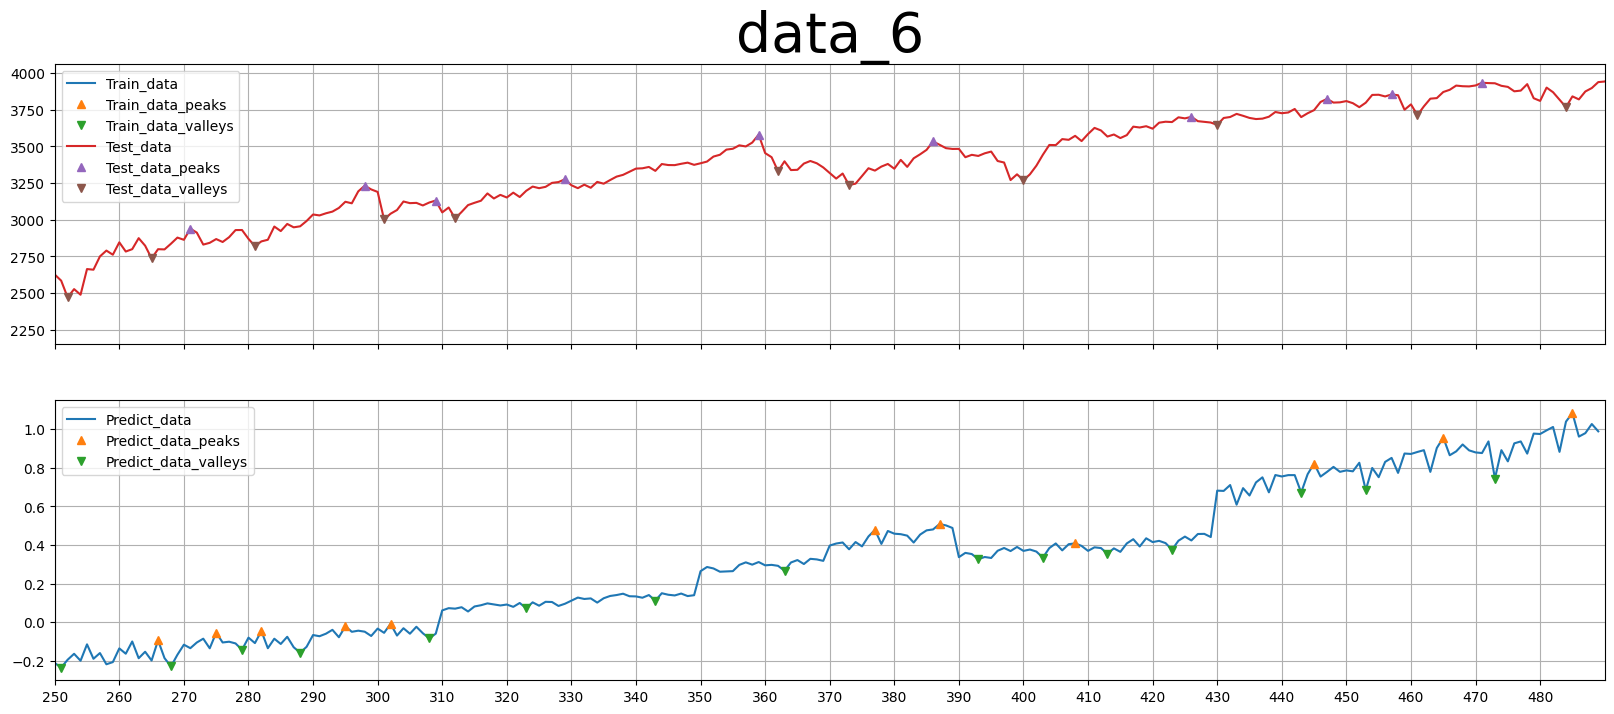

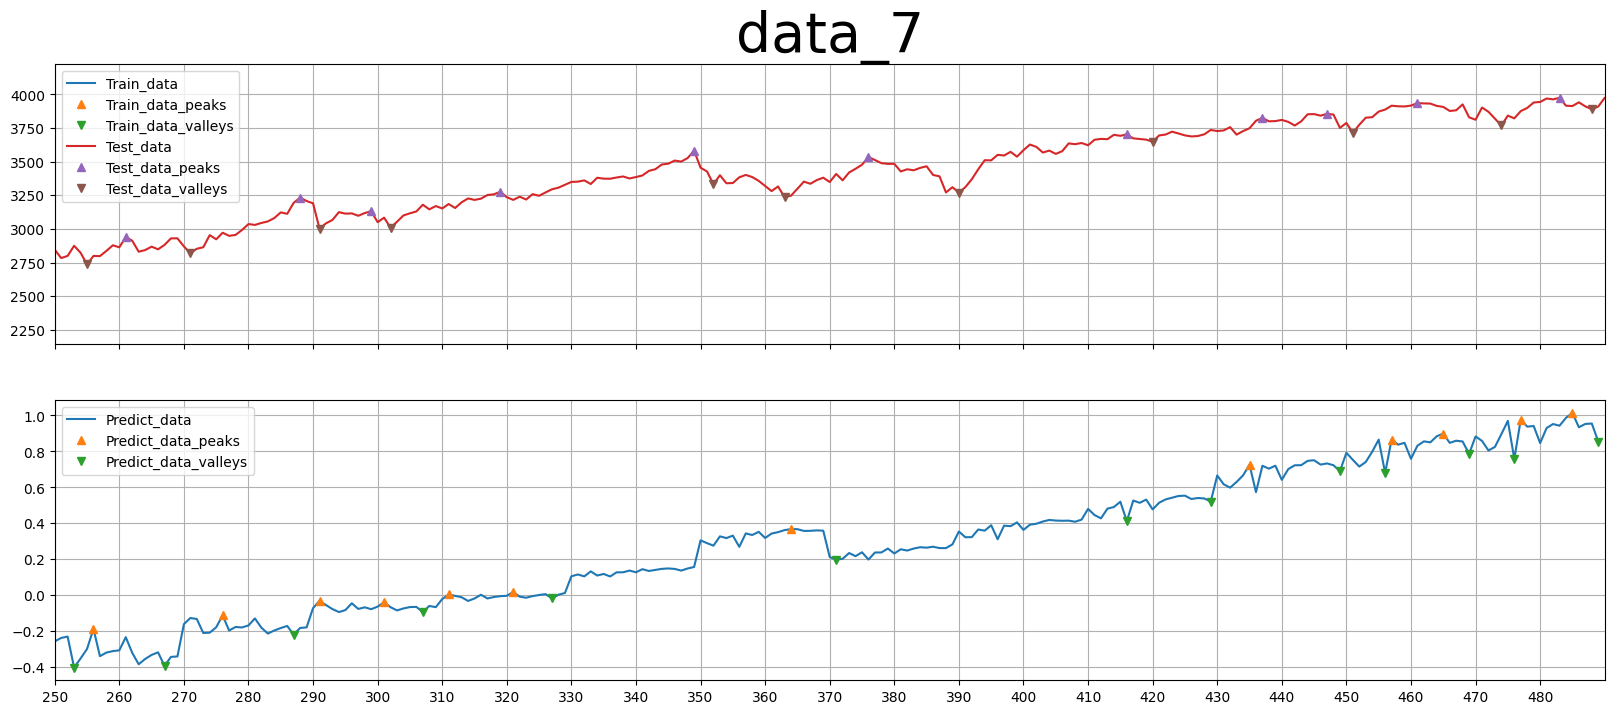

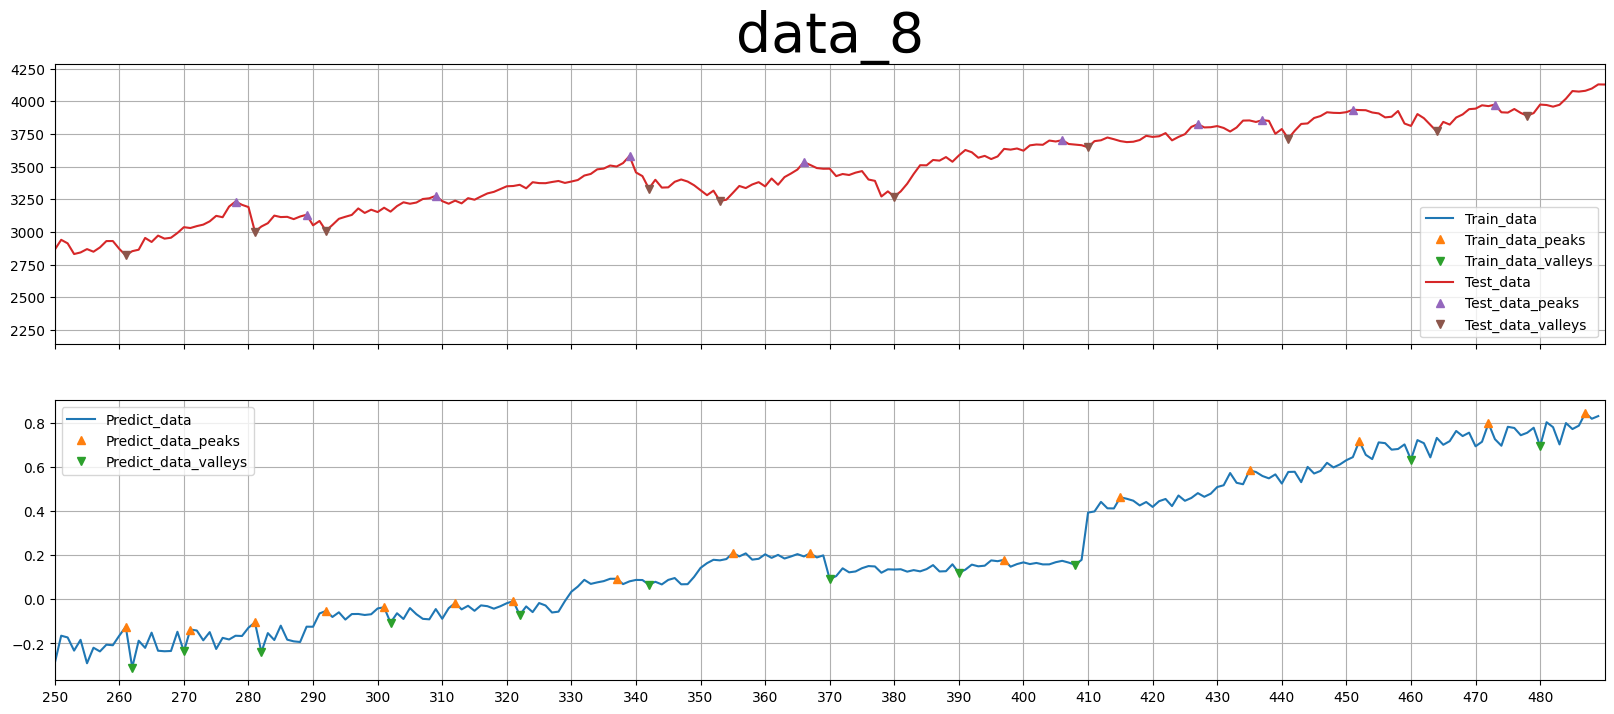

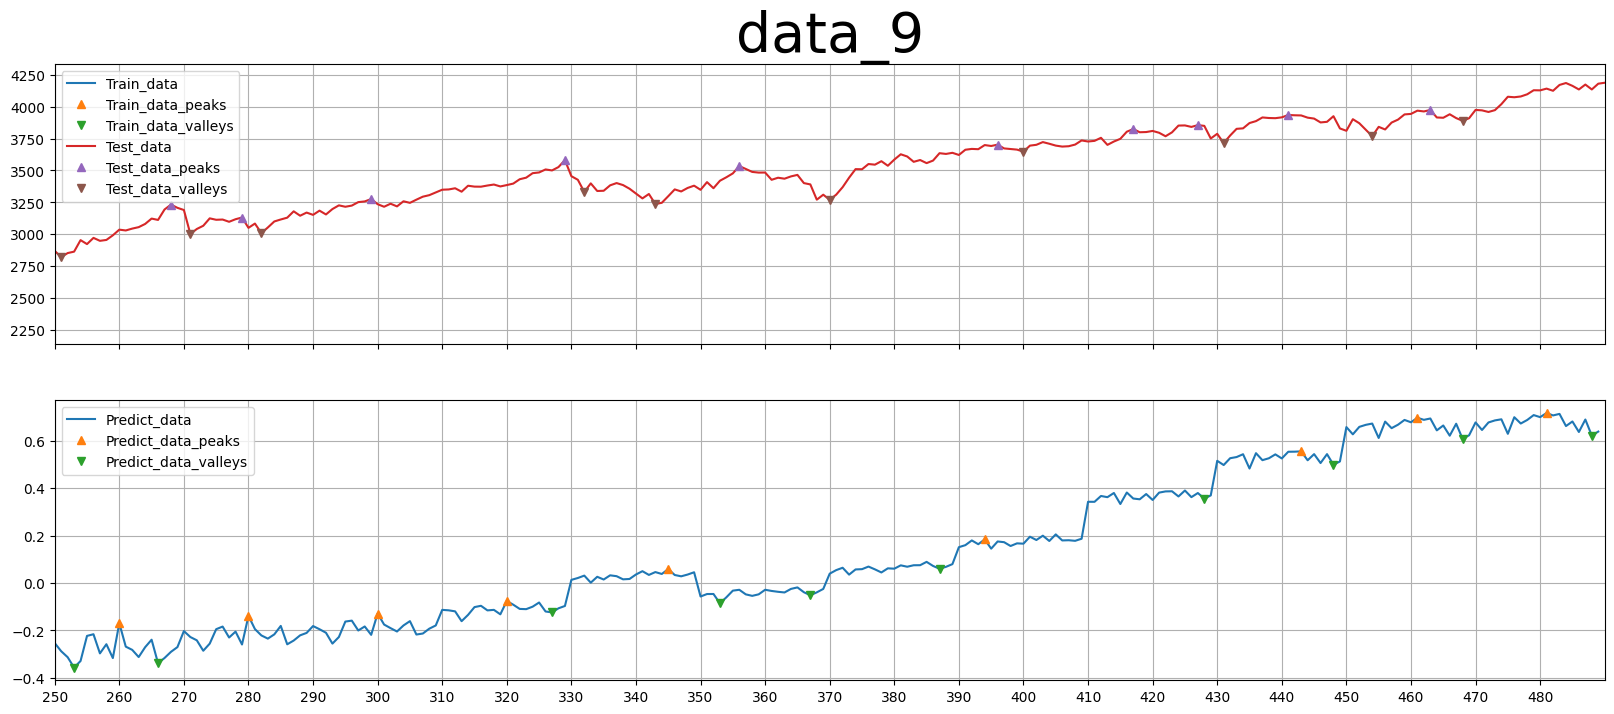

In [63]:
for i in processed_signal:
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'], label='Train_data')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^', label='Train_data_peaks')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v', label='Train_data_valleys')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'], label='Test_data')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^', label='Test_data_peaks')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v', label='Test_data_valleys')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'], label='Predict_data')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^', label='Predict_data_peaks')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v', label='Predict_data_valleys')
    plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
    axes[0].grid()
    axes[1].grid()
    axes[0].legend()
    axes[1].legend()
    plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
    plt.show()

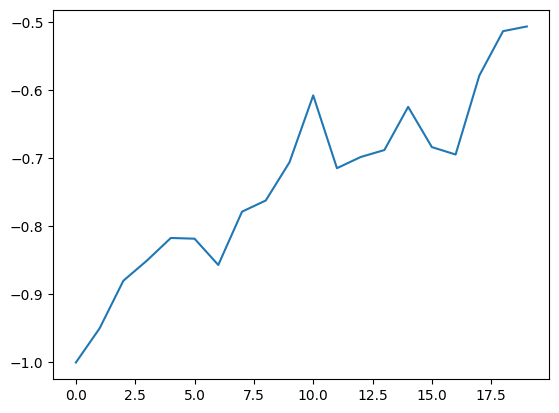

In [64]:
plt.plot(x_train['data_0'][0])

In [65]:
x_train['data_0'].shape[1]

20

In [66]:
for j in range(0, x_train[i].shape[1]):
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [67]:
len(x_train[i][0])

20

In [68]:
# x_start = 0
# x_end = x_start+slide
# for i in x_train:
#     x_start_copy = x_start
#     fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
#     axes[0].set_title(i, fontsize=40)
#     for j in range(0, x_train[i].shape[0]):
#         axes[0].plot(range(x_start, x_end), x_train[i][j], label=f'x_train_{j}')
#         axes[1].plot(range(x_end, x_end+slide), y_train[i][j], label=f'y_train_{j}')
#         x_start+=slide
#         x_end+=slide
#     axes[0].grid()
#     axes[1].grid()
#     axes[0].legend()
#     axes[1].legend()
#     plt.xticks(np.arange(x_start_copy, x_end, step=10))
#     plt.show()

In [69]:
processed_signal['data_0'][0]['Close'].values

array([ 0.18295188,  0.16165498,  0.15388973,  0.13428243,  0.11318925,
        0.11916278,  0.13684238,  0.1104442 ,  0.101866  ,  0.12809083,
        0.09608711,  0.06464218,  0.08193757,  0.11094978,  0.14592177,
        0.10443547,  0.10498682,  0.12244377,  0.11808299,  0.12589689,
        0.22829016,  0.2058748 ,  0.1873006 ,  0.15957232,  0.13007614,
        0.13829763,  0.15808395,  0.12493163,  0.10288239,  0.1420375 ,
        0.10135286,  0.05962025,  0.06882884,  0.11864365,  0.17104512,
        0.09973551,  0.09983684,  0.1276848 ,  0.12723485,  0.13373959,
        0.22882365,  0.19689867,  0.17787397,  0.14795294,  0.12664704,
        0.13782981,  0.15564053,  0.12003854,  0.09365439,  0.13657324,
        0.10459351,  0.05694105,  0.06717529,  0.11131278,  0.18142594,
        0.10656334,  0.10025553,  0.13299836,  0.12918721,  0.14188862,
       -0.3688146 , -0.42173526, -0.32540676, -0.37009388, -0.29469386,
       -0.24019502, -0.23821722, -0.20857431, -0.22783564, -0.21

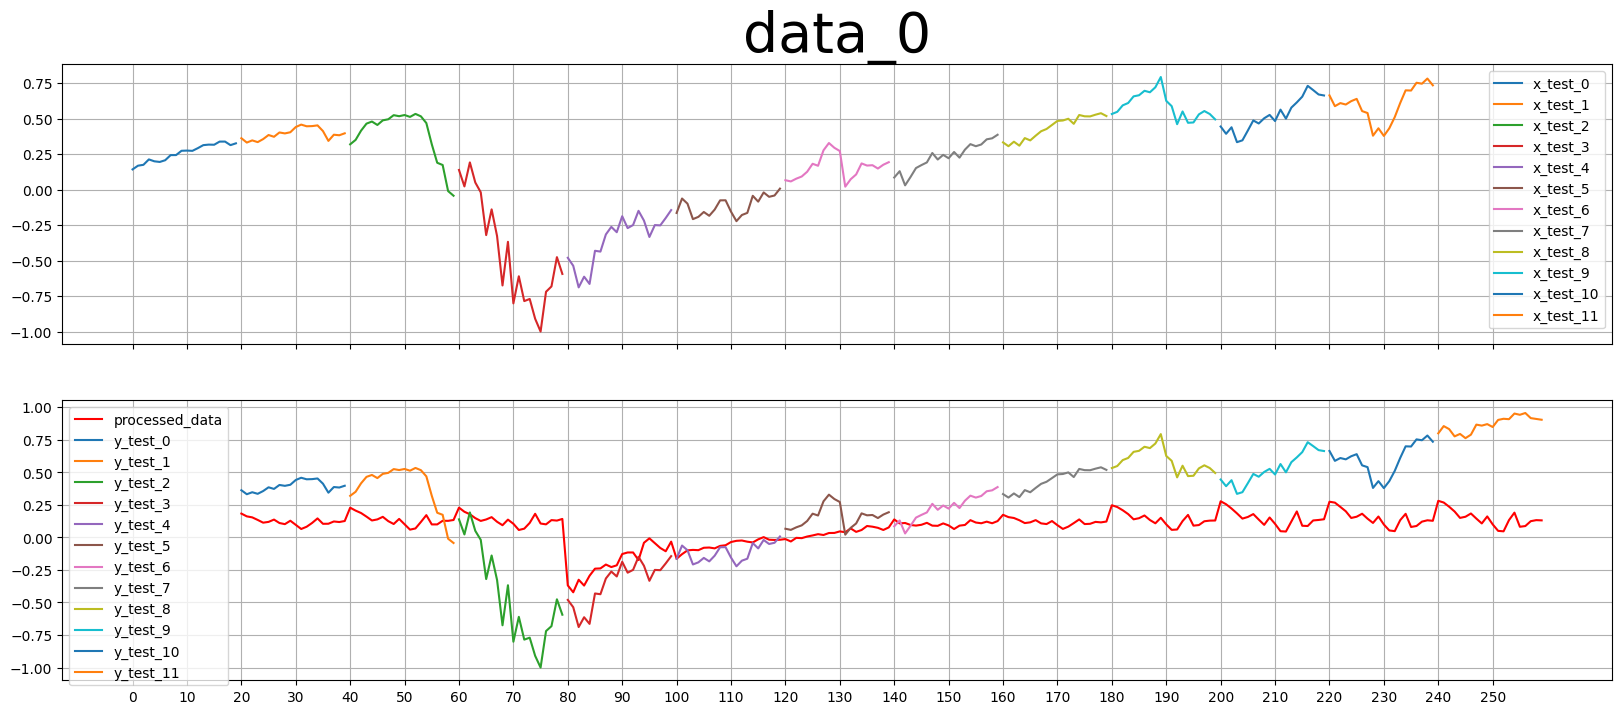

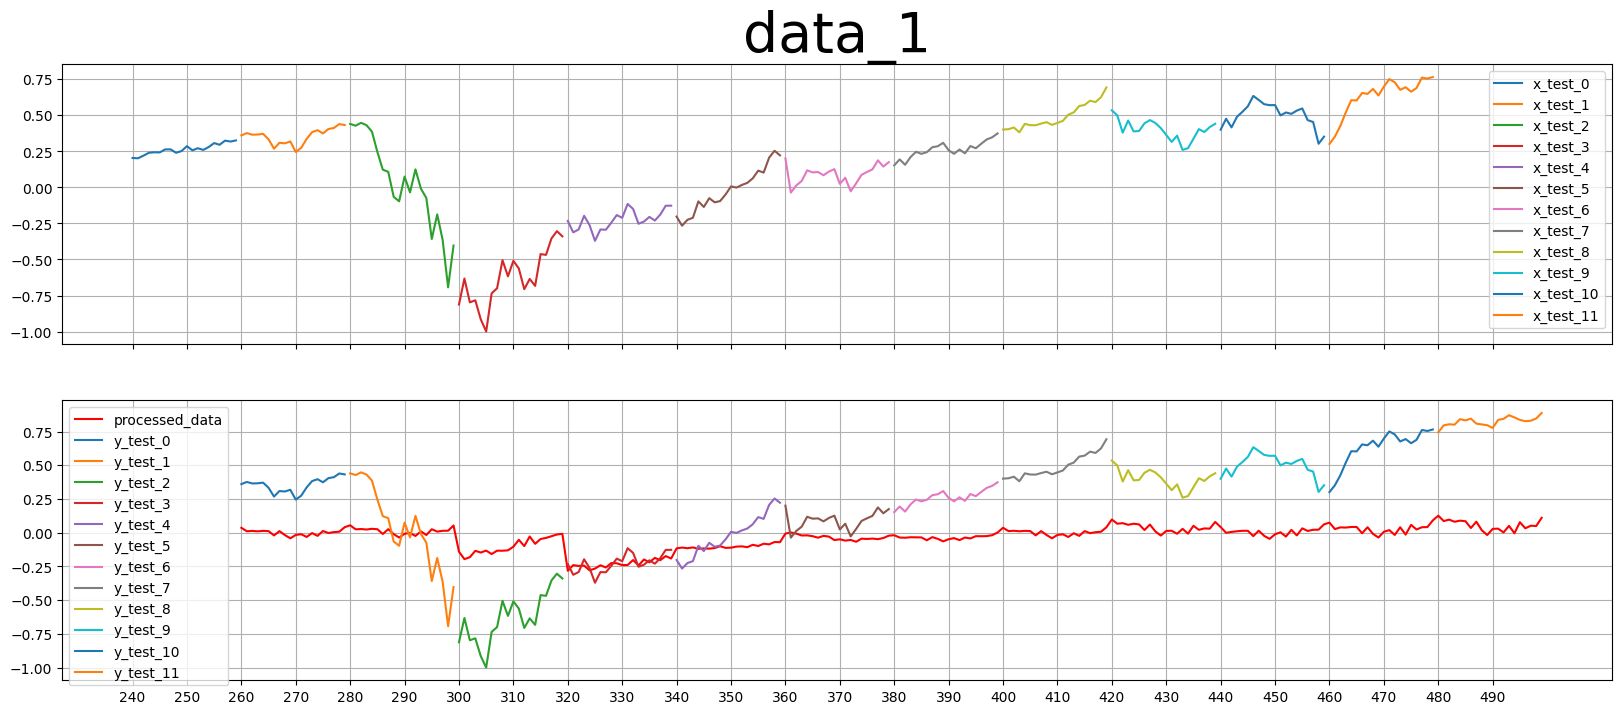

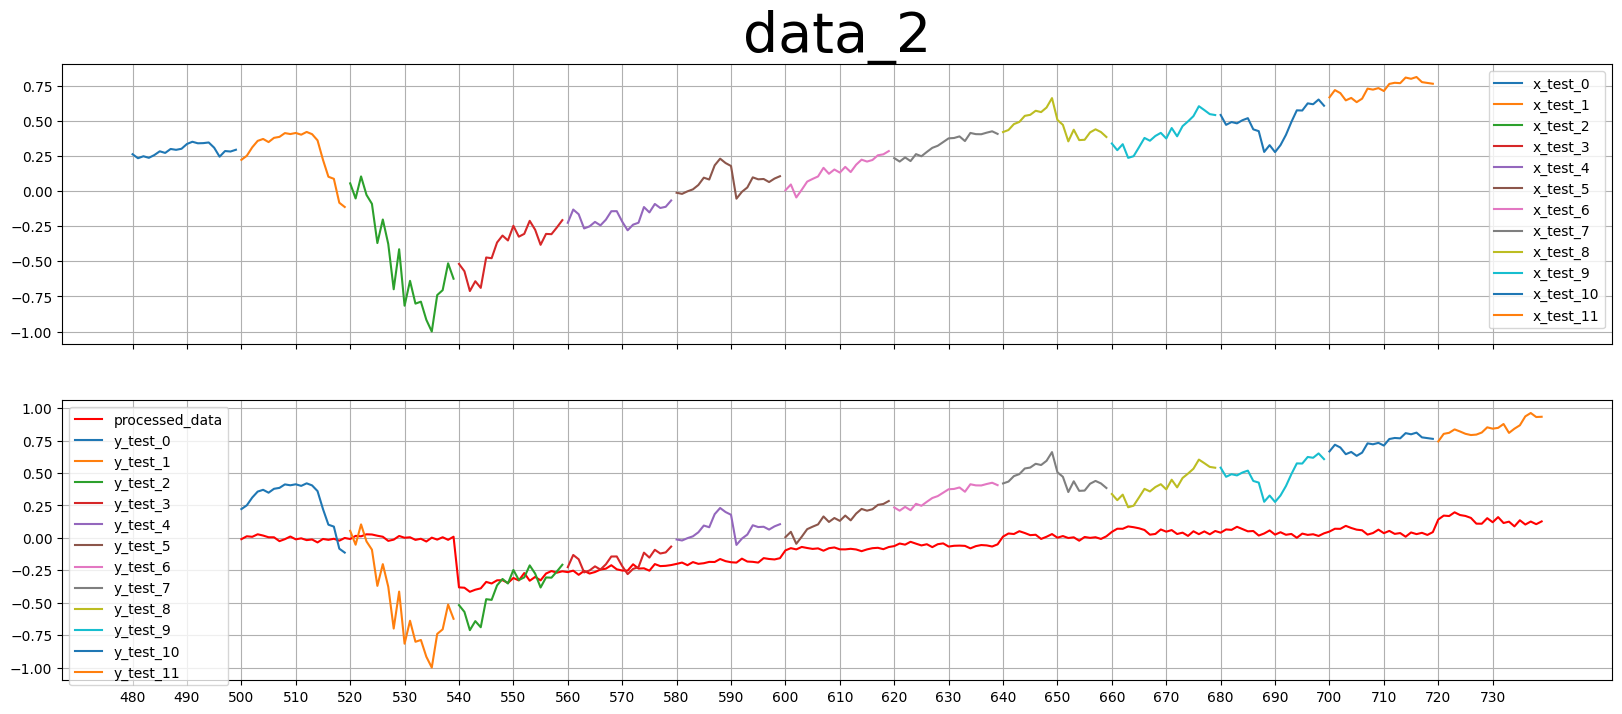

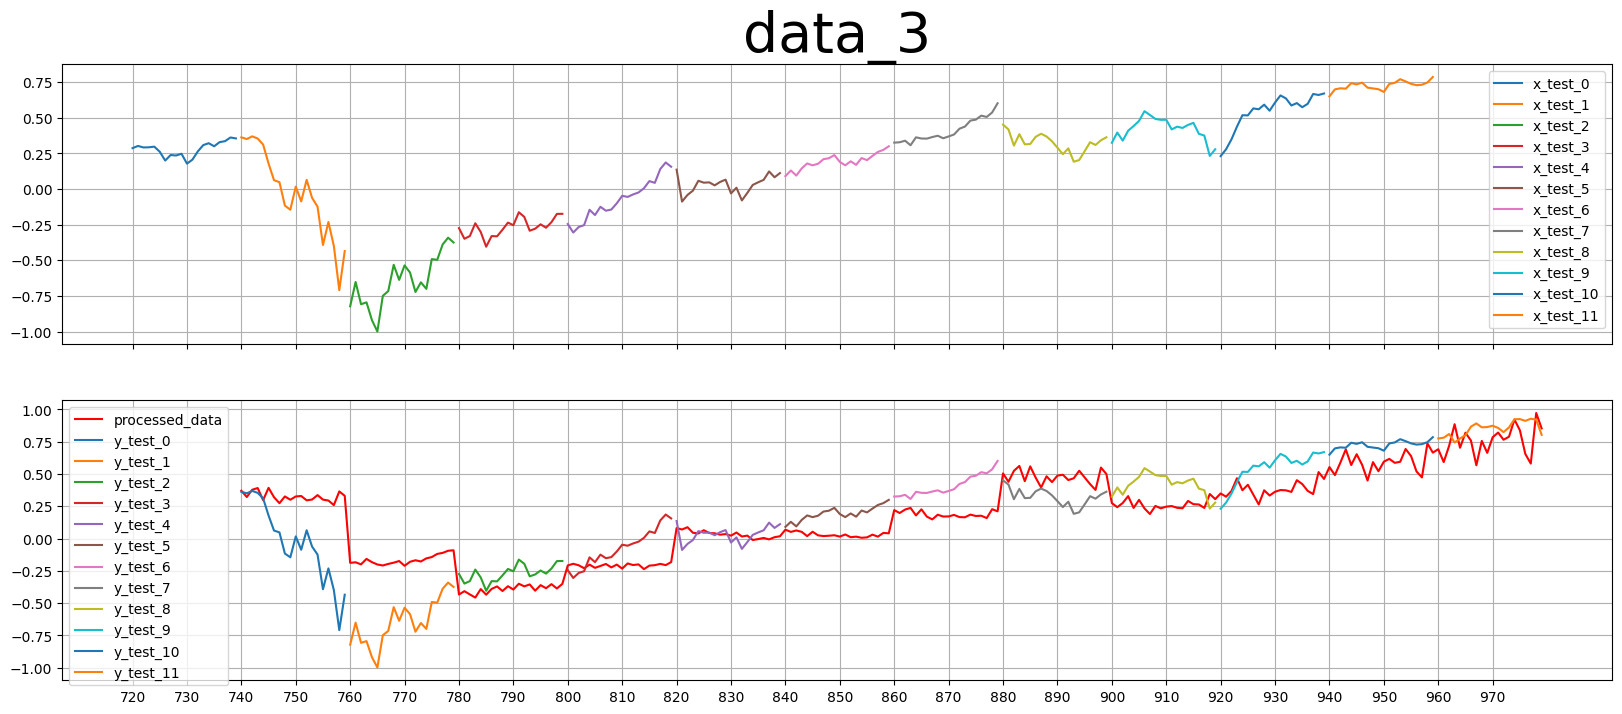

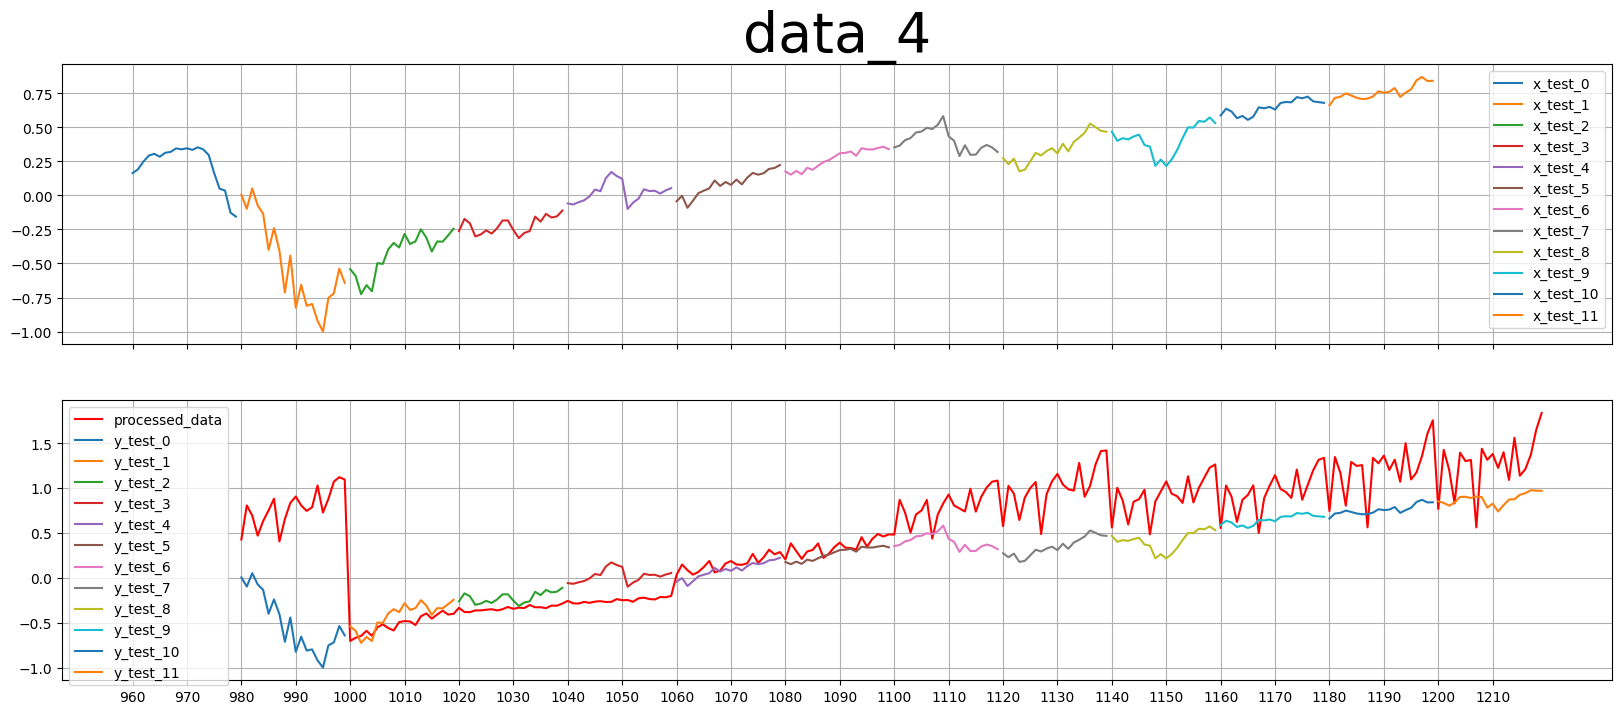

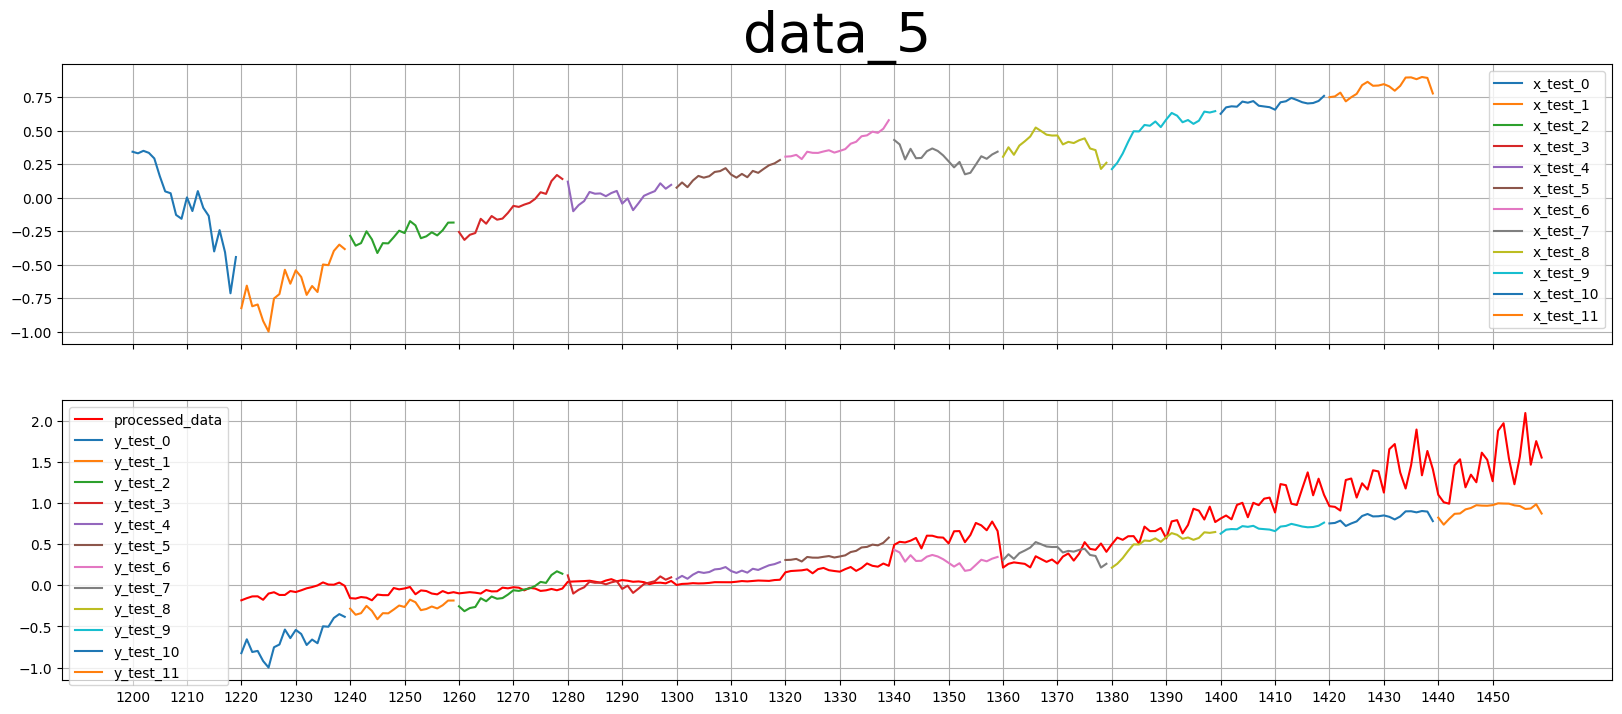

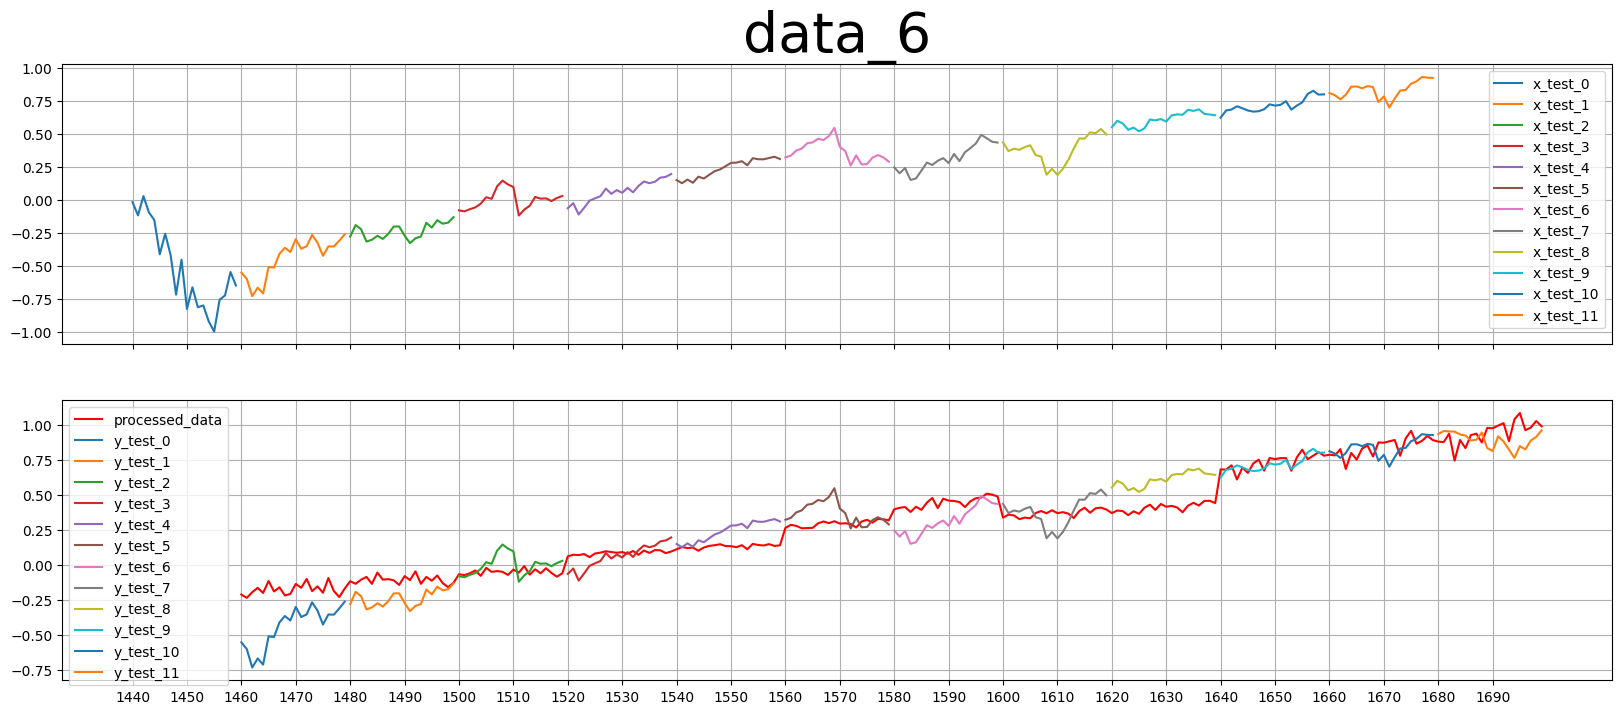

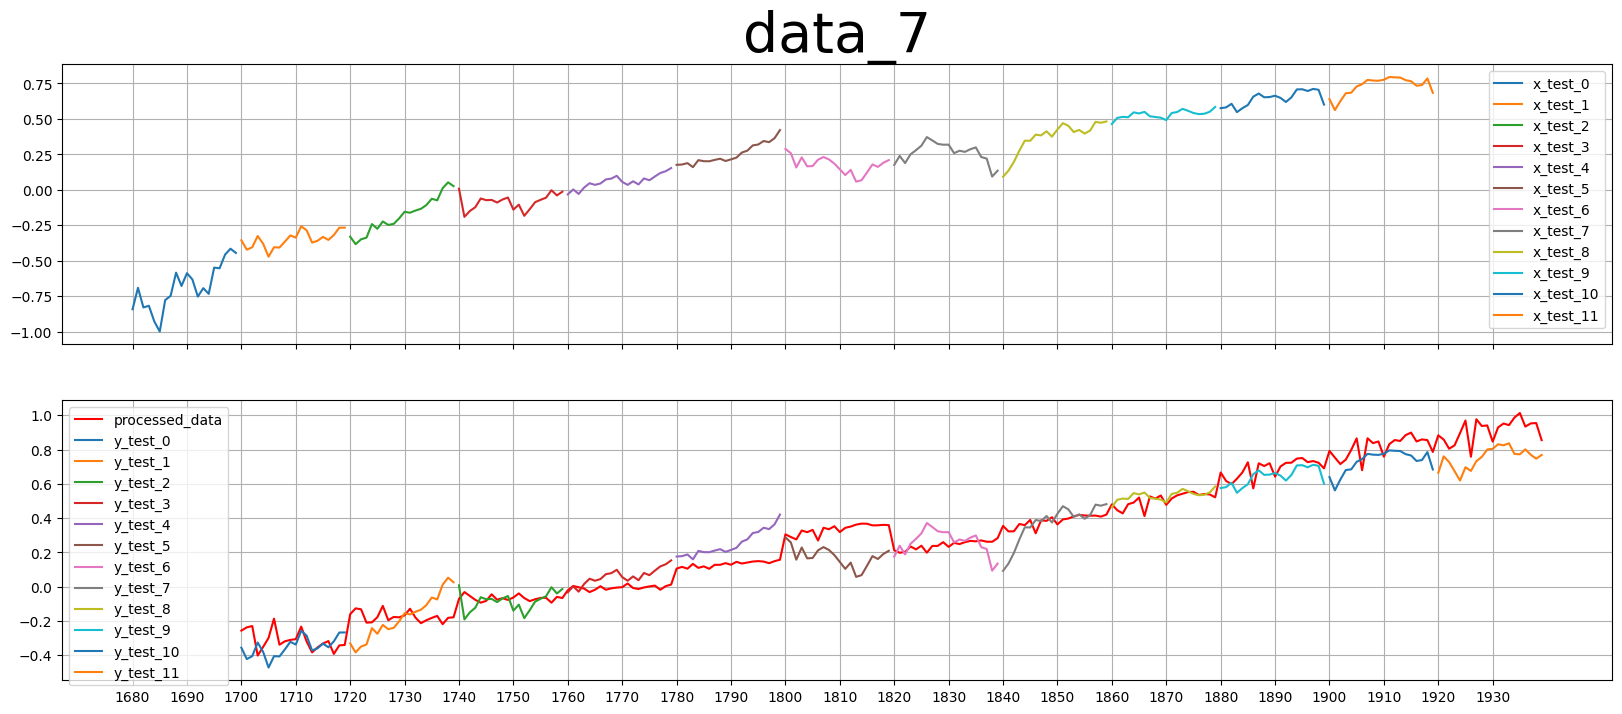

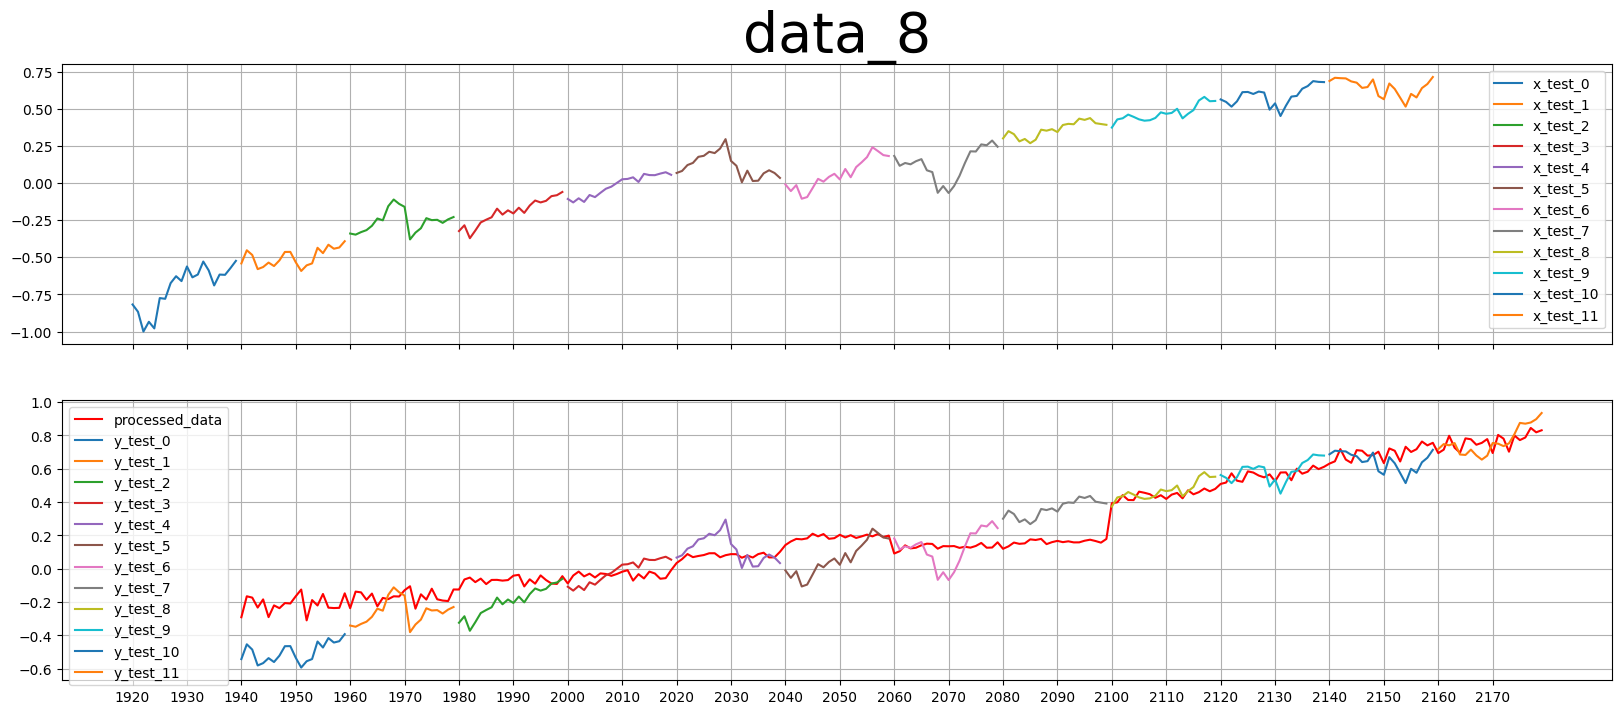

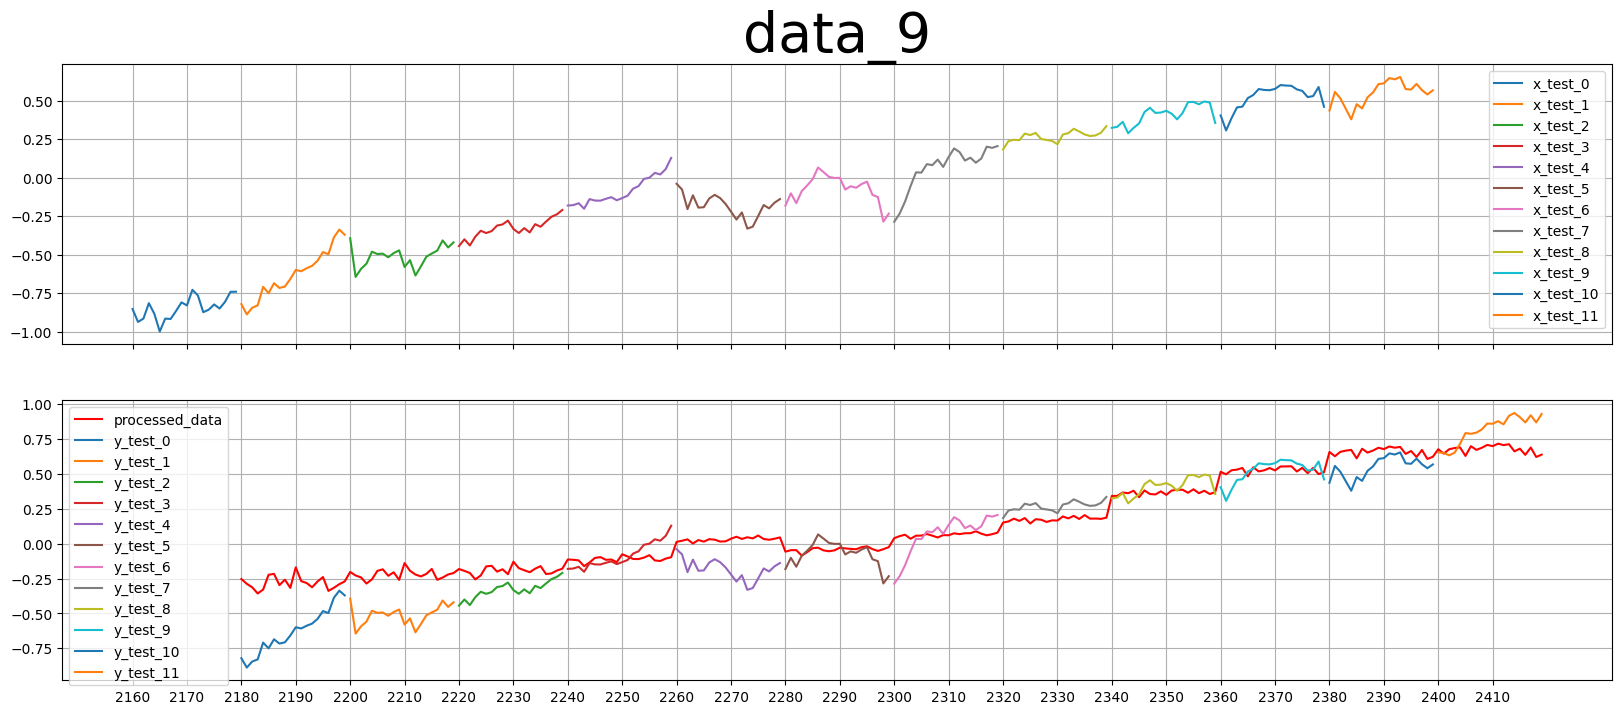

In [70]:
x_start = 0
x_end = x_start+slide
for i in x_test:
    x_start_copy = x_start
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    plot_processed_data = processed_signal[i][0]['Close'].values
    axes[1].plot(range(x_end, x_end+len(plot_processed_data)), plot_processed_data, 'r',label=f'processed_data')
    for j in range(0, x_test[i].shape[0]):
        axes[0].plot(range(x_start, x_end), x_test[i][j], label=f'x_test_{j}')
        axes[1].plot(range(x_end, x_end+slide), y_test[i][j], label=f'y_test_{j}')
        x_start+=slide
        x_end+=slide
    
    axes[0].grid()
    axes[1].grid()
    axes[0].legend()
    axes[1].legend()
    plt.xticks(np.arange(x_start_copy, x_end, step=10))
    plt.show()